### Data Generation

In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as splinalg
import time
import matplotlib.pyplot as plt
import random

In [2]:
def random_gen_dense(size, density):
    dense_matrix = np.random.rand(*size)
    mask = np.random.rand(*size) > density
    dense_matrix[mask] = 0
    return dense_matrix

def convert_to_csr(matrix):
    return sp.csr_matrix(matrix)

### Algorithms

In [3]:
def lanczos(A, k):
    n, m = A.shape
    Q = np.zeros((n, k + 1))
    alpha = np.zeros(k)
    beta = np.zeros(k + 1)
    q = np.random.normal(size=n)
    q /= np.linalg.norm(q)
    Q[:, 0] = q

    for i in range(k):
        z = A.dot(q) if sp.issparse(A) else A @ q
        alpha[i] = (q.T.dot(z) if sp.issparse(A) else q.T @ z).item()  
        if i > 0:
            z -= alpha[i] * q + beta[i] * Q[:, i - 1]
        else:
            z -= alpha[i] * q
        beta[i + 1] = np.linalg.norm(z)
        q = z / beta[i + 1]
        Q[:, i + 1] = q

    T = np.diag(alpha) + np.diag(beta[1:k], k=1) + np.diag(beta[1:k], k=-1)
    return T, Q

In [4]:
def ols(X, y):
    if sp.issparse(X):
        XTX = X.T.dot(X)
        XTy = X.T.dot(y)
        XTX_inv = splinalg.inv(XTX)
        beta = XTX_inv.dot(XTy)
    else:
        XTX = X.T @ X
        XTy = X.T @ y
        XTX_inv = np.linalg.inv(XTX)
        beta = XTX_inv @ XTy
    return beta

In [5]:
def gradient_descent(X, y, learning_rate=0.01, epochs=100, return_history=False):
    
    m, n = X.shape
    theta = np.zeros(n)
    cost_history = []

    for epoch in range(epochs):
        predictions = X.dot(theta) if sp.issparse(X) else X @ theta
        error = predictions - y
        gradient = (1/m) * (X.T.dot(error) if sp.issparse(X) else X.T @ error)
        theta -= learning_rate * gradient
        if return_history:
            cost = np.mean(error**2) / 2  
            cost_history.append(cost)

    return (theta, cost_history) if return_history else theta

In [6]:
def svd_with_lanczos(A, k):
    m, n = A.shape
    if m >= n:
        T, Q = lanczos_algorithm(A.T @ A, k)
    else:
        T, Q = lanczos_algorithm(A @ A.T, k)

    eigvals, eigvecs = np.linalg.eigh(T)
    singular_values = np.sqrt(np.abs(eigvals))
    V = Q[:, :k] @ eigvecs

    for i in range(V.shape[1]):
        V[:, i] /= np.linalg.norm(V[:, i]) if np.linalg.norm(V[:, i]) != 0 else 1

    U = A @ V

    return U, singular_values[:k], V.T

### Performance Evaluation

In [7]:
def time_algorithm(algorithm, *args):
    start_time = time.time()
    results = algorithm(*args)
    end_time = time.time()
    return end_time - start_time, results

In [8]:
def calculate_sparsity(matrix):
    total_elements = matrix.size
    non_zero_elements = np.count_nonzero(matrix)
    zero_elements = total_elements - non_zero_elements
    sparsity_percentage = (zero_elements / total_elements) * 100
    return sparsity_percentage


In [9]:
times = []
sparsity_percentages = []
dense_times = []
csr_times = []


for i in np.arange(100):
    size = (1000, 1000)
    density = 0.1
    dense_matrix = generate_random_dense_matrix(size, density)
    csr_matrix = convert_to_csr(dense_matrix)
    sparsity_percentage = calculate_sparsity(dense_matrix)
    sparsity_percentages.append(sparsity_percentage)

    k = 10  
    lanczos_dense_time, _ = time_algorithm(lanczos_algorithm, dense_matrix, k)
    lanczos_csr_time, _ = time_algorithm(lanczos_algorithm, csr_matrix, k)
    times.append(lanczos_dense_time - lanczos_csr_time)
    dense_times.append(lanczos_dense_time)
    csr_times.append(lanczos_csr_time)
    
print(f"Min Time Difference: {min(times)} seconds")
print(f"Max Time Difference: {max(times)} seconds")
print(f"Speedup Percentage: {sum(i > 0 for i in times)/len(times)}")


Min Time Difference: -0.00045418739318847656 seconds
Max Time Difference: 0.0519556999206543 seconds
Speedup Percentage: 0.94


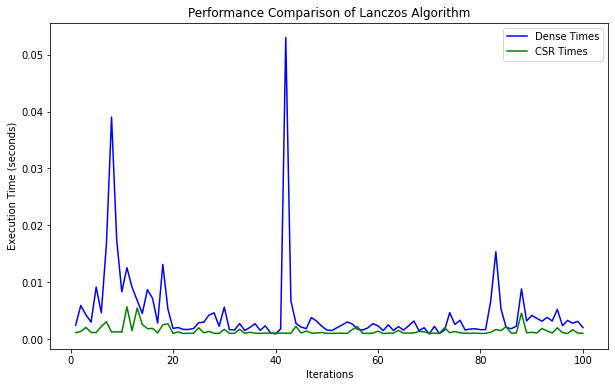

In [10]:
iterations = range(1, len(dense_times) + 1)

plt.figure(figsize=(10, 6))
plt.plot(iterations, dense_times, label='Dense Times', color='blue')
plt.plot(iterations, csr_times, label='CSR Times', color='green')

plt.title('Performance Comparison of Lanczos Algorithm')
plt.xlabel('Iterations')
plt.ylabel('Execution Time (seconds)')
plt.legend()

plt.show()

In [11]:
times = []
sparsity_percentages = []
dense_times = []
csr_times = []


for i in np.arange(250):
    size = (1000, 1000)
    density = random.uniform(0.1, 0.9)
    dense_matrix = generate_random_dense_matrix(size, density)
    csr_matrix = convert_to_csr(dense_matrix)
    sparsity_percentage = calculate_sparsity(dense_matrix)
    sparsity_percentages.append(sparsity_percentage)

    
    k = 10  
    lanczos_dense_time, _ = time_algorithm(lanczos_algorithm, dense_matrix, k)
    lanczos_csr_time, _ = time_algorithm(lanczos_algorithm, csr_matrix, k)
    times.append(lanczos_dense_time - lanczos_csr_time)
    dense_times.append(lanczos_dense_time)
    csr_times.append(lanczos_csr_time)
    
print(f"Min Time Difference: {min(times)} seconds")
print(f"Max Time Difference: {max(times)} seconds")
print(f"Speedup Percentage: {sum(i > 0 for i in times)/len(times)}")



Min Time Difference: -0.028021812438964844 seconds
Max Time Difference: 0.06086468696594238 seconds
Speedup Percentage: 0.2


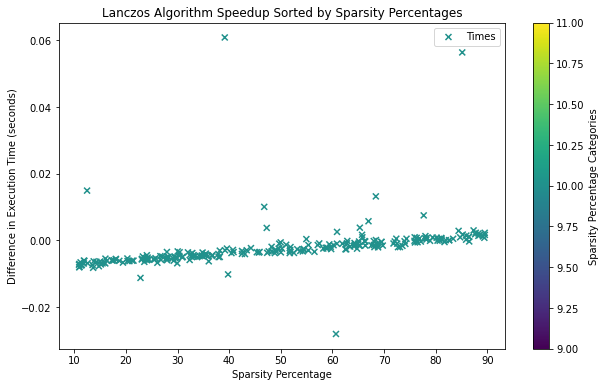

In [12]:
categories = np.digitize(sparsity_percentages, bins=np.arange(0, 1, 0.1))

plt.figure(figsize=(10, 6))
scatter = plt.scatter(sparsity_percentages, times, c=categories, cmap='viridis', marker='x', label='Times')

cbar = plt.colorbar(scatter)
cbar.set_label('Sparsity Percentage Categories')

plt.title('Lanczos Algorithm Speedup Sorted by Sparsity Percentages')
plt.xlabel('Sparsity Percentage')
plt.ylabel('Difference in Execution Time (seconds)')
plt.legend()


plt.show()

In [13]:
#OLS
times = []
sparsity_percentages = []
dense_times = []
csr_times = []

for i in np.arange(100):
    size = (1000, 1000)
    density = 0.1
    dense_matrix = generate_random_dense_matrix(size, density)
    csr_matrix = convert_to_csr(dense_matrix)
    y = np.random.rand(1000)
    #X_csr = sp.csr_matrix(X_dense)
    sparsity_percentage = calculate_sparsity(dense_matrix)
    sparsity_percentages.append(sparsity_percentage)
    ols_time_dense, result_dense = time_algorithm(ols, dense_matrix, y)
    ols_time_csr, result_csr = time_algorithm(ols, csr_matrix, y)
    times.append(ols_time_dense - ols_time_csr)
    dense_times.append(ols_time_dense)
    csr_times.append(ols_time_csr)

print(f"Min Time Difference: {min(times)} seconds")
print(f"Max Time Difference: {max(times)} seconds")
print(f"Speedup Percentage: {sum(i > 0 for i in times)/len(times)}")

Min Time Difference: -1.4582066535949707 seconds
Max Time Difference: -0.8074755668640137 seconds
Speedup Percentage: 0.0


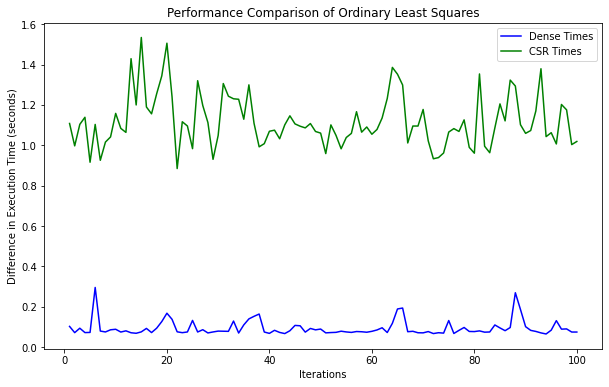

In [14]:
iterations = range(1, len(dense_times) + 1)

plt.figure(figsize=(10, 6))
plt.plot(iterations, dense_times, label='Dense Times', color='blue')
plt.plot(iterations, csr_times, label='CSR Times', color='green')

plt.title('Performance Comparison of Ordinary Least Squares')
plt.xlabel('Iterations')
plt.ylabel('Difference in Execution Time (seconds)')
plt.legend()

plt.show()

In [15]:
#OLS
times = []
sparsity_percentages = []
dense_times = []
csr_times = []

for i in np.arange(250):
    size = (1000, 1000)
    density = random.uniform(0.1, 0.9)
    dense_matrix = generate_random_dense_matrix(size, density)
    csr_matrix = convert_to_csr(dense_matrix)
    y = np.random.rand(1000)
    #X_csr = sp.csr_matrix(X_dense)
    sparsity_percentage = calculate_sparsity(dense_matrix)
    sparsity_percentages.append(sparsity_percentage)
    ols_time_dense, result_dense = time_algorithm(ols, dense_matrix, y)
    ols_time_csr, result_csr = time_algorithm(ols, csr_matrix, y)
    times.append(ols_time_dense - ols_time_csr)
    dense_times.append(ols_time_dense)
    csr_times.append(ols_time_csr)

print(f"Min Time Difference: {min(times)} seconds")
print(f"Max Time Difference: {max(times)} seconds")
print(f"Speedup Percentage: {sum(i > 0 for i in times)/len(times)}")

Min Time Difference: -1.819500207901001 seconds
Max Time Difference: -0.8165130615234375 seconds
Speedup Percentage: 0.0


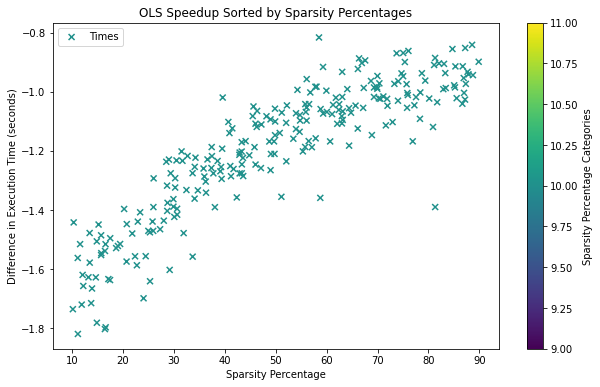

In [16]:
categories = np.digitize(sparsity_percentages, bins=np.arange(0, 1, 0.1))

plt.figure(figsize=(10, 6))
scatter = plt.scatter(sparsity_percentages, times, c=categories, cmap='viridis', marker='x', label='Times')

cbar = plt.colorbar(scatter)
cbar.set_label('Sparsity Percentage Categories')

plt.title('OLS Speedup Sorted by Sparsity Percentages')
plt.xlabel('Sparsity Percentage')
plt.ylabel('Difference in Execution Time (seconds)')
plt.legend()

plt.show()

In [17]:
#Gradient Descent
times = []
sparsity_percentages = []
dense_times = []
csr_times = []

for i in np.arange(100):
    size = (1000, 1000)
    density = 0.1
    dense_matrix = generate_random_dense_matrix(size, density)
    csr_matrix = convert_to_csr(dense_matrix)
    y = np.random.rand(1000)
    sparsity_percentage = calculate_sparsity(dense_matrix)
    sparsity_percentages.append(sparsity_percentage)

    gr_time_dense, result_dense = time_algorithm(gradient_descent, dense_matrix, y)

    gr_time_csr, result_csr = time_algorithm(gradient_descent, csr_matrix, y)
    times.append(gr_time_dense - gr_time_csr)
    dense_times.append(gr_time_dense)
    csr_times.append(gr_time_csr)

print(f"Min Time Difference: {min(times)} seconds")
print(f"Max Time Difference: {max(times)} seconds")
print(f"Speedup Percentage: {sum(i > 0 for i in times)/len(times)}")

Min Time Difference: 0.007582187652587891 seconds
Max Time Difference: 0.0709390640258789 seconds
Speedup Percentage: 1.0


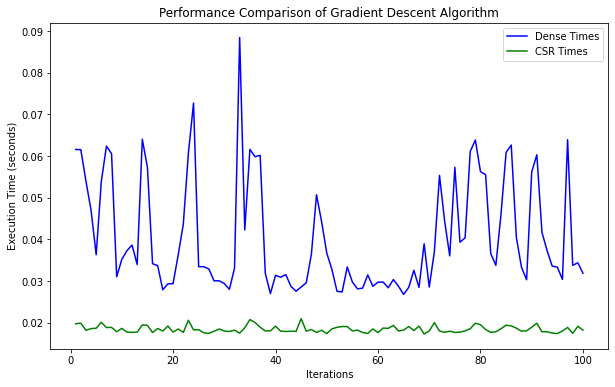

In [18]:
iterations = range(1, len(dense_times) + 1)

plt.figure(figsize=(10, 6))
plt.plot(iterations, dense_times, label='Dense Times', color='blue')
plt.plot(iterations, csr_times, label='CSR Times', color='green')

plt.title('Performance Comparison of Gradient Descent Algorithm')
plt.xlabel('Iterations')
plt.ylabel('Execution Time (seconds)')
plt.legend()

plt.show()

In [19]:
#Gradient Descent
times = []
sparsity_percentages = []
dense_times = []
csr_times = []

for i in np.arange(100):
    size = (1000, 1000)
    density = random.uniform(0.1, 0.9)
    dense_matrix = generate_random_dense_matrix(size, density)
    csr_matrix = convert_to_csr(dense_matrix)
    y = np.random.rand(1000)
    sparsity_percentage = calculate_sparsity(dense_matrix)
    sparsity_percentages.append(sparsity_percentage)

    gr_time_dense, result_dense = time_algorithm(gradient_descent, dense_matrix, y)

    gr_time_csr, result_csr = time_algorithm(gradient_descent, csr_matrix, y)
    times.append(gr_time_dense - gr_time_csr)
    dense_times.append(gr_time_dense)
    csr_times.append(gr_time_csr)

print(f"Min Time Difference: {min(times)} seconds")
print(f"Max Time Difference: {max(times)} seconds")
print(f"Speedup Percentage: {sum(i > 0 for i in times)/len(times)}")

Min Time Difference: -0.11241459846496582 seconds
Max Time Difference: 0.04305100440979004 seconds
Speedup Percentage: 0.21


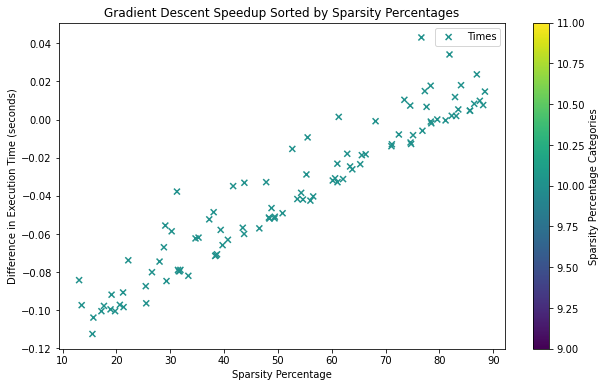

In [20]:
categories = np.digitize(sparsity_percentages, bins=np.arange(0, 1, 0.1))

plt.figure(figsize=(10, 6))
scatter = plt.scatter(sparsity_percentages, times, c=categories, cmap='viridis', marker='x', label='Times')

cbar = plt.colorbar(scatter)
cbar.set_label('Sparsity Percentage Categories')

plt.title('Gradient Descent Speedup Sorted by Sparsity Percentages')
plt.xlabel('Sparsity Percentage')
plt.ylabel('Difference in Execution Time (seconds)')
plt.legend()

plt.show()

In [21]:
times = []
sparsity_percentages = []
dense_times = []
csr_times = []

for i in range(100):
    size = (1000, 1000)
    density = 0.1
    dense_matrix = generate_random_dense_matrix(size, density)
    csr_matrix = convert_to_csr(dense_matrix)
    sparsity_percentage = calculate_sparsity(dense_matrix)
    sparsity_percentages.append(sparsity_percentage)

    k = 10  
    lanczos_dense_time, _ = time_algorithm(np.linalg.svd, dense_matrix, k)
    lanczos_csr_time, _ = time_algorithm(svd_with_lanczos, csr_matrix, k)
    times.append(lanczos_dense_time - lanczos_csr_time)
    dense_times.append(lanczos_dense_time)
    csr_times.append(lanczos_csr_time)

print(f"Min Time Difference: {min(times)} seconds")
print(f"Max Time Difference: {max(times)} seconds")
print(f"Speedup Percentage: {sum(i > 0 for i in times) / len(times)}")

Min Time Difference: 0.7302968502044678 seconds
Max Time Difference: 1.0788488388061523 seconds
Speedup Percentage: 1.0


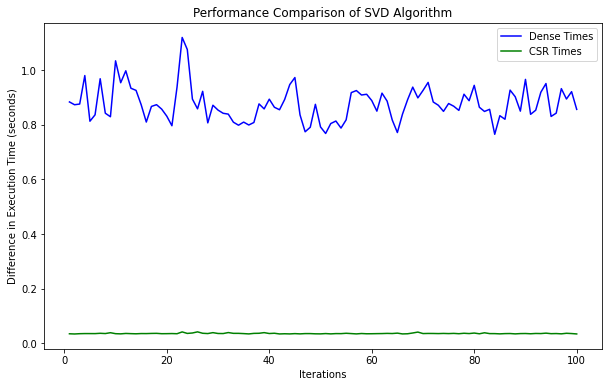

In [22]:
iterations = range(1, len(dense_times) + 1)

plt.figure(figsize=(10, 6))
plt.plot(iterations, dense_times, label='Dense Times', color='blue')
plt.plot(iterations, csr_times, label='CSR Times', color='green')

plt.title('Performance Comparison of SVD Algorithm')
plt.xlabel('Iterations')
plt.ylabel('Difference in Execution Time (seconds)')
plt.legend()

plt.show()

In [23]:
times = []
sparsity_percentages = []
dense_times = []
csr_times = []

for i in range(250):
    size = (1000, 1000)
    density = random.uniform(0.1, 0.9)
    dense_matrix = generate_random_dense_matrix(size, density)
    csr_matrix = convert_to_csr(dense_matrix)
    sparsity_percentage = calculate_sparsity(dense_matrix)
    sparsity_percentages.append(sparsity_percentage)

    k = 10  
    lanczos_dense_time, _ = time_algorithm(np.linalg.svd, dense_matrix, k)
    lanczos_csr_time, _ = time_algorithm(svd_with_lanczos, csr_matrix, k)
    times.append(lanczos_dense_time - lanczos_csr_time)
    dense_times.append(lanczos_dense_time)
    csr_times.append(lanczos_csr_time)

print(f"Min Time Difference: {min(times)} seconds")
print(f"Max Time Difference: {max(times)} seconds")
print(f"Speedup Percentage: {sum(i > 0 for i in times) / len(times)}")

Min Time Difference: -0.09268784523010254 seconds
Max Time Difference: 1.7116522789001465 seconds
Speedup Percentage: 0.976


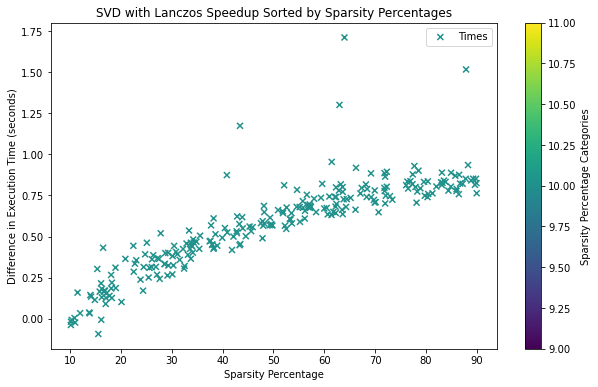

In [24]:
categories = np.digitize(sparsity_percentages, bins=np.arange(0, 1, 0.1))

plt.figure(figsize=(10, 6))
scatter = plt.scatter(sparsity_percentages, times, c=categories, cmap='viridis', marker='x', label='Times')

cbar = plt.colorbar(scatter)
cbar.set_label('Sparsity Percentage Categories')

plt.title('SVD with Lanczos Speedup Sorted by Sparsity Percentages')
plt.xlabel('Sparsity Percentage')
plt.ylabel('Difference in Execution Time (seconds)')
plt.legend()
plt.show()